In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
max_degree = 20  # 最大阶数
n_train, n_test = 100, 100  # 训练集和测试集大小

true_w = np.zeros(max_degree)  # 初始化系数,指数从0到20
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])  # 只给0-3次方x赋系数，其余取0

features = np.random.normal(size=(n_train+n_test, 1))

# print(features.shape)  # (200, 1)
np.random.shuffle(features)  # 打乱顺序
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

# features.shape, np.arange(max_degree).reshape(1, -1).shape, poly_features.shape  # ((200, 1), (1, 20), (200, 20))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [18]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2, :], labels[:2]

C:\Users\admin\AppData\Local\Temp\ipykernel_28572\822253556.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]


(tensor([[-2.6655],
         [ 2.3647]]),
 tensor([[ 1.0000e+00, -2.6655e+00,  3.5523e+00, -3.1562e+00,  2.1032e+00,
          -1.1212e+00,  4.9807e-01, -1.8966e-01,  6.3190e-02, -1.8714e-02,
           4.9882e-03, -1.2087e-03,  2.6848e-04, -5.5048e-05,  1.0481e-05,
          -1.8624e-06,  3.1025e-07, -4.8645e-08,  7.2034e-09, -1.0105e-09],
         [ 1.0000e+00,  2.3647e+00,  2.7959e+00,  2.2038e+00,  1.3028e+00,
           6.1617e-01,  2.4284e-01,  8.2035e-02,  2.4249e-02,  6.3712e-03,
           1.5066e-03,  3.2388e-04,  6.3823e-05,  1.1609e-05,  1.9609e-06,
           3.0913e-07,  4.5687e-08,  6.3551e-09,  8.3489e-10,  1.0391e-10]]),
 tensor([-28.0517,  10.6716]))

In [19]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [20]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9816904  1.1951339 -3.4001021  5.603981 ]]


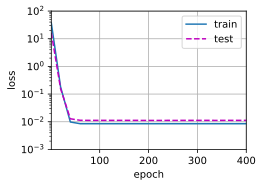

In [23]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.6252925 6.0692554]]


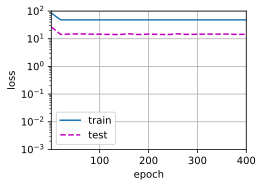

In [24]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9717765e+00  1.2641199e+00 -3.3288023e+00  5.2935114e+00
  -3.0704728e-01  7.7078140e-01  7.5763267e-01 -4.3540993e-01
   3.9614058e-01 -3.9233983e-02  2.0813376e-01 -1.0240817e-01
   1.7916037e-01 -3.9355601e-03 -8.8197567e-02 -1.4332937e-01
   1.4654860e-01 -1.9815204e-01 -1.5086442e-01  1.3493350e-01]]


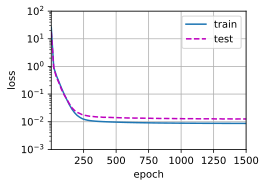

In [26]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [27]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [28]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [29]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.8554],
         [-1.0579]]),
 tensor([[ 1.0000e+00,  8.5540e-01,  3.6585e-01,  1.0432e-01,  2.2308e-02,
           3.8165e-03,  5.4410e-04,  6.6489e-05,  7.1093e-06,  6.7570e-07,
           5.7799e-08,  4.4947e-09,  3.2039e-10,  2.1082e-11,  1.2881e-12,
           7.3456e-14,  3.9271e-15,  1.9760e-16,  9.3906e-18,  4.2277e-19],
         [ 1.0000e+00, -1.0579e+00,  5.5961e-01, -1.9734e-01,  5.2193e-02,
          -1.1043e-02,  1.9472e-03, -2.9428e-04,  3.8916e-05, -4.5745e-06,
           4.8395e-07, -4.6544e-08,  4.1034e-09, -3.3393e-10,  2.5234e-11,
          -1.7797e-12,  1.1767e-13, -7.3230e-15,  4.3040e-16, -2.3965e-17]]),
 tensor([5.3506, 0.8766]))

In [30]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [31]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0140443  1.202501  -3.4184103  5.5532174]]


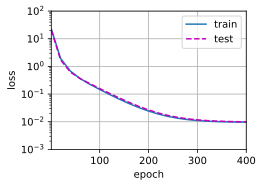

In [32]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.1757014 3.5920827]]


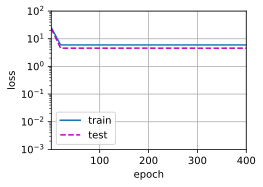

In [33]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.970721    1.2168185  -3.191369    5.310592   -0.7024368   1.1804105
   0.13670214  0.06741217  0.17229933  0.11121126  0.19166559 -0.21700577
  -0.12781343 -0.09146889  0.06468376  0.08823936 -0.05631687 -0.14082097
   0.17294425  0.04644752]]


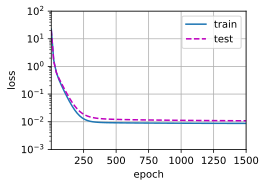

In [34]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)